In [1]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install opencv-contrib-python
!pip install opencv-python 
!pip install tensorflow  
!pip install pandas 
!pip install numpy
!pip install cv2 
!pip install matplotlib 
!pip install keras 
!pip install scikit-learn 
%pip install seaborn  
import os
import pickle  #object to byte and byte to object conversion
import matplotlib.pyplot as plt
import keras
import keras.utils
import pandas as pd
import numpy as np
import cv2
import seaborn as sns

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



In [4]:

from keras.utils import to_categorical
from keras.layers import  MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten

import matplotlib.pyplot as plt

from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.applications import VGG16
from keras.applications import ResNet50
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Lambda, Activation, Flatten, Input
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, RMSprop, SGD

from keras.utils import to_categorical
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from Attention import attention #importing attention layer
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix



In [5]:
#define global variabels
X = [] #use to store image data
Y = [] #use to store label
P = [] #use to store bounding box or defect probability
labels = ['Mono', 'Poly']

dataset = pd.read_csv("Dataset/labels.csv", header=None, delimiter=r"\s+")
dataset

,0,1,2
0,images/cell0001.png,1.0,mono
1,images/cell0002.png,1.0,mono
2,images/cell0003.png,1.0,mono
3,images/cell0004.png,0.0,mono
4,images/cell0005.png,1.0,mono
...,...,...,...
2619,images/cell2620.png,0.0,poly
2620,images/cell2621.png,0.0,poly
2621,images/cell2622.png,0.0,poly
2622,images/cell2623.png,0.0,poly


In [6]:
#laod images and class labels from the dataset
if os.path.exists('model/X.txt.npy'):
    X = np.load('model/X.txt.npy')#load all processed images
    Y = np.load('model/Y.txt.npy')                    
    P = np.load('model/P.txt.npy')
else:#start processing images
    dataset = dataset.values
    for i in range(len(dataset)):#loop all images from dataset
        img = cv2.imread("Dataset/"+dataset[i,0])#read image from given path
        img = cv2.resize(img, (32, 32), interpolation = cv2.INTER_CUBIC) #scale imaage
        img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)#hsv transform
        img = cv2.flip(img, 1)#flip images
        prob = dataset[i,1]
        label = dataset[i,2]
        X.append(img) #add image features to X
        if label.strip() == 'mono': #add 0 as label for MONO and 1 for PLOY
            Y.append(0)
        else:
            Y.append(1)
        P.append([prob])#add probability of defect in the image
    X = np.asarray(X)#convert to mosaic and mixup
    Y = np.asarray(Y)
    P = np.asarray(P)
    np.save('model/X.txt',X)#save all processed images
    np.save('model/Y.txt',Y)                    
    np.save('model/P.txt',P)  
print("Dataset Images Loading Completed")
print("Total Images Found in Dataset : "+str(X.shape[0]))
print("Class Labels in dataset : "+str(labels))

Dataset Images Loading Completed
Total Images Found in Dataset : 2624
Class Labels in dataset : ['Mono', 'Poly']


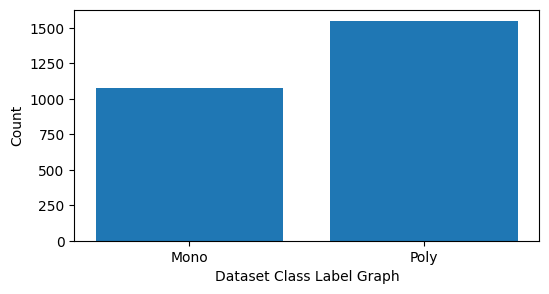

In [7]:
#find and plot images in each class label
unqiue, count = np.unique(Y, return_counts = True)
height = count
bars = labels
y_pos = np.arange(len(bars))#position of y
plt.figure(figsize =(6, 3)) 
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.xlabel("Dataset Class Label Graph")
plt.ylabel("Count")
plt.show()

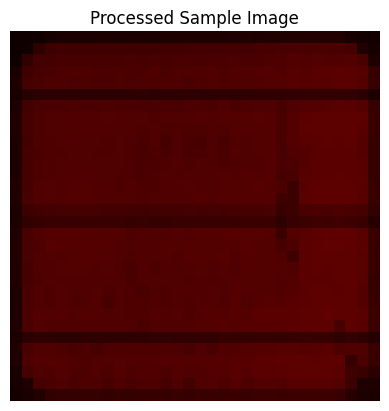

In [8]:
#display sample process image
img = X[0]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('Processed Sample Image')
plt.axis('off')
plt.show()

In [9]:
#preprocess image features and then split dataset into train and test
indices = np.arange(X.shape[0])
np.random.shuffle(indices)#shuffle image pixels
X = X[indices]
Y = Y[indices]
P = P[indices]
Y = to_categorical(Y)
#split dataset into train and test where 20% dataset size for testing and 80% for testing
split = train_test_split(X, Y, P, test_size=0.20, random_state=42)
(trainImages, testImages) = split[:2] #get train and test images
(trainLabels, testLabels) = split[2:4]#get train and test labels
(trainBBoxes, testBBoxes) = split[4:6]#get train bounding boxes as probability
print()
print("Dataset train & test split as 80% dataset for training and 20% for testing")
print("Training Size (80%): "+str(trainImages.shape[0])) #print training and test size
print("Testing Size (20%): "+str(testImages.shape[0]))
print()


Dataset train & test split as 80% dataset for training and 20% for testing
Training Size (80%): 2099
Testing Size (20%): 525



In [10]:
#define global variables to calculate and store accuracy and other metrics
precision = []
recall = []
fscore = []
accuracy = []
mAP = []

In [11]:
#function to calculate various metrics such as accuracy, precision etc
def calculateMetrics(algorithm, predict, testY):
    p = precision_score(testY, predict,average='macro') * 100
    r = recall_score(testY, predict,average='macro') * 100
    f = f1_score(testY, predict,average='macro') * 100
    a = accuracy_score(testY,predict)*100     
    ma = average_precision_score(testY,predict)*100
    print(algorithm+' Accuracy  : '+str(a))
    print(algorithm+' Precision : '+str(p))
    print(algorithm+' Recall    : '+str(r))
    print(algorithm+' FSCORE    : '+str(f))    
    print(algorithm+' mAP       : '+str(ma))
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    mAP.append(ma)
    conf_matrix = confusion_matrix(testY, predict) 
    plt.figure(figsize =(5, 4)) 
    ax = sns.heatmap(conf_matrix, xticklabels = labels, yticklabels = labels, annot = True, cmap="viridis" ,fmt ="g");
    ax.set_ylim([0,len(labels)])
    plt.title(algorithm+" Confusion matrix") 
    plt.ylabel('True class') 
    plt.xlabel('Predicted class') 
    plt.show()

17/17 [==============================] - 4s 110ms/step
Faster RCNN Accuracy  : 89.52380952380953
Faster RCNN Precision : 89.02440800396121
Faster RCNN Recall    : 90.77745990199956
Faster RCNN FSCORE    : 89.32299466427058
Faster RCNN mAP       : 91.95673143527274


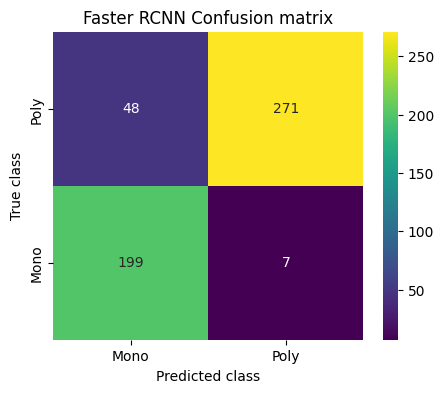

In [12]:
#train existing FRCNN model
#using Resnet50 pretrained model as the base structure for the FasterRCNN
rcnn = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(X.shape[1], X.shape[2], X.shape[3])))
rcnn.trainable = False
#get output
flatten = rcnn.output
#define FRCNN layers by converting multi dimension input features as single dimension
flatten = Flatten()(flatten)
#define FRCNN layer with 16 neurons for features filtration by using flatten
bboxHead = Dense(16, activation="relu")(flatten)
#define layer for bounding box probability
bboxHead = Dense(8, activation="relu")(bboxHead)
bboxHead = Dense(8, activation="relu")(bboxHead)
#define prediction for bounding boxes
bboxHead = Dense(1, activation="sigmoid", name="bounding_box")(bboxHead)
#define another layer for images training 
softmaxHead = Dense(16, activation="relu")(flatten)
softmaxHead = Dropout(0.2)(softmaxHead)
softmaxHead = Dense(8, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.2)(softmaxHead)
#define classification layer as two classes Mono and Poly
softmaxHead = Dense(2, activation="softmax", name="class_label")(softmaxHead)
frcnn_model = Model(inputs=rcnn.input, outputs=(bboxHead, softmaxHead))
losses = {"class_label": "categorical_crossentropy", "bounding_box": "mean_squared_error"}
lossWeights = {"class_label": 1.0, "bounding_box": 1.0}
opt = Adam(lr=1e-4)
#compile and train the model
frcnn_model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)
if os.path.exists("model/frcnn.hdf5") == False:
    trainTargets = {"class_label": trainLabels, "bounding_box": trainBBoxes}
    testTargets = {"class_label": testLabels, "bounding_box": testBBoxes}
    model_check_point = ModelCheckpoint(filepath='model/frcnn.hdf5', verbose = 1, save_best_only = True)
    hist = frcnn_model.fit(trainImages, trainTargets, validation_data=(testImages, testTargets), batch_size=32, epochs=10, verbose=1,callbacks=[model_check_point])
    f = open('model/frcnn.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()
else:
    frcnn_model = load_model('model/frcnn.hdf5')
predict = frcnn_model.predict(testImages)[1]#perform prediction on test data
predict = np.argmax(predict, axis=1)
testY = np.argmax(testLabels, axis=1)
calculateMetrics("Faster RCNN", predict, testY)#call this function to calculate accuracy and other metrics

17/17 [==============================] - 1s 16ms/step
YoloV5 Accuracy  : 98.09523809523809
YoloV5 Precision : 98.48024316109422
YoloV5 Recall    : 97.57281553398059
YoloV5 FSCORE    : 97.98461396720104
YoloV5 mAP       : 96.96048632218846


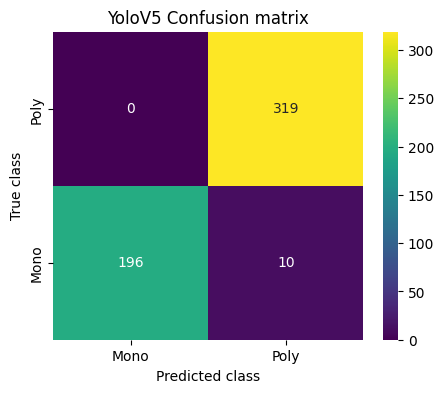

In [13]:
#train propose YoloV5 with CA attention model
#define input shape
input_img = Input(shape=(32, 32, 3))
#create YoloV4 layers with 32, 64 and 512 neurons or data filteration size
x = Conv2D(32, (3, 3), padding = 'same', activation = 'relu')(input_img)
x = Conv2D(32, (3, 3), padding = 'same', activation = 'relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(x)
x = Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(x)
x = MaxPooling2D((2, 2))(x)
#adding CA attention layer
x = attention(return_sequences=True,name='attention')(x)#==============adding attention layer
x = Flatten()(x)
#define output layer with 4 bounding box coordinate and 1 weapan class
x = Dense(512, activation = 'relu')(x)
x = Dense(512, activation = 'relu')(x)
x_bb = Dense(1, name='bb')(x)
x_class = Dense(2, activation='softmax', name='class')(x)
#create yolo Model with above input details
yolo_model = Model([input_img], [x_bb, x_class])
#compile the model
yolo_model.compile(Adam(lr=0.001), loss=['mse', 'categorical_crossentropy'], metrics=['accuracy'])
if os.path.exists("model/yolo_weights.hdf5") == False:#if model not trained then train the model
    model_check_point = ModelCheckpoint(filepath='model/yolo_weights.hdf5', verbose = 1, save_best_only = True)
    hist = yolo_model.fit(trainImages, [trainBBoxes, trainLabels], batch_size=32, epochs=10, validation_split=0.2, callbacks=[model_check_point])
    f = open('model/yolo_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:#if model already trained then load it
    yolo_model = load_model("model/yolo_weights.hdf5", custom_objects={'attention': attention})
predict = yolo_model.predict(testImages)#perform prediction on test data
predict = np.argmax(predict[1], axis=1)
test = np.argmax(testLabels, axis=1)
calculateMetrics("YoloV5", predict, test)#call this function to calculate accuracy and other metrics

In [14]:
pip install efficientnet

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


17/17 [==============================] - 3s 130ms/step
YoloV6 Accuracy  : 98.85714285714286
YoloV6 Precision : 99.07692307692308
YoloV6 Recall    : 98.54368932038835
YoloV6 FSCORE    : 98.7952452345256
YoloV6 mAP       : 98.15384615384616


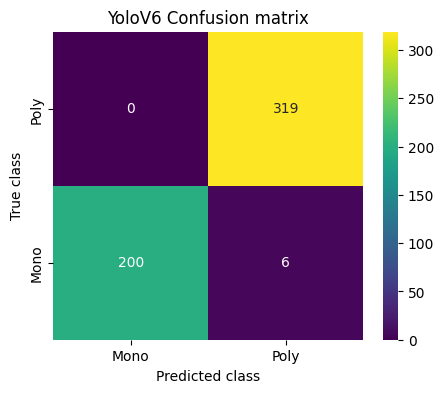

In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import pickle
import os

# Load pre-trained EfficientNet model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(X.shape[1], X.shape[2], X.shape[3]))
base_model.trainable = False

# Define new layers for YoloV6
bboxHead = Dense(16, activation="relu")(base_model.output)
bboxHead = Dense(8, activation="relu")(bboxHead)
bboxHead = Dense(8, activation="relu")(bboxHead)
bboxHead = Dense(1, activation="sigmoid", name="bounding_box")(bboxHead)

softmaxHead = Dense(16, activation="relu")(base_model.output)
softmaxHead = Dropout(0.2)(softmaxHead)
softmaxHead = Dense(8, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.2)(softmaxHead)
softmaxHead = Dense(2, activation="softmax", name="class_label")(softmaxHead)

# Create YoloV6 model
yolov6_model = Model(inputs=base_model.input, outputs=(bboxHead, softmaxHead))

# Define parameters
losses = {"class_label": "categorical_crossentropy", "bounding_box": "mean_squared_error"}
lossWeights = {"class_label": 1.0, "bounding_box": 1.0}
trainTargets = {"class_label": trainLabels, "bounding_box": trainBBoxes}
testTargets = {"class_label": testLabels, "bounding_box": testBBoxes}
opt = Adam(lr=1e-4)

# Compile and train the model
yolov6_model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)

if os.path.exists("model/yolov6.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/yolov6.hdf5', verbose = 1, save_best_only = True)
    hist = yolov6_model.fit(trainImages, trainTargets, validation_data=(testImages, testTargets), batch_size=32, epochs=10, verbose=1,callbacks=[model_check_point])
    f = open('model/yolov6.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()
else:
    yolov6_model = load_model('model/yolov6.hdf5')

predict = yolov6_model.predict(testImages)[1]
predict = np.argmax(predict, axis=1)
testY = np.argmax(testLabels, axis=1)
calculateMetrics("YoloV6", predict, testY)

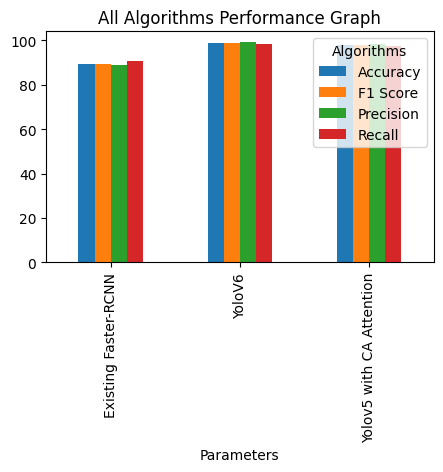

In [16]:
#all algorithm Perfromnace Graph
df = pd.DataFrame([['Existing Faster-RCNN','Precision',precision[0]],['Existing Faster-RCNN','Recall',recall[0]],['Existing Faster-RCNN','F1 Score',fscore[0]],['Existing Faster-RCNN','Accuracy',accuracy[0]],
                   ['Yolov5 with CA Attention','Precision',precision[1]],['Yolov5 with CA Attention','Recall',recall[1]],['Yolov5 with CA Attention','F1 Score',fscore[1]],['Yolov5 with CA Attention','Accuracy',accuracy[1]],
                   ['YoloV6','Precision',precision[2]],['YoloV6','Recall',recall[2]],['YoloV6','F1 Score',fscore[2]],['YoloV6','Accuracy',accuracy[2]],
                  ],columns=['Parameters','Algorithms','Value'])
df.pivot(index="Parameters", columns="Algorithms", values="Value").plot(kind='bar', figsize =(5, 3))
plt.title("All Algorithms Performance Graph")
plt.show()

In [17]:
#showing all algorithms with scenario A and B performance values
columns = ["Algorithm Name","Precison","Recall","FScore","Accuracy"]
values = []
algorithm_names = ["Existing Faster-RCNN","YoloV5 with CA Attention", "YoloV6"]
for i in range(len(algorithm_names)):
    values.append([algorithm_names[i],precision[i],recall[i],fscore[i],accuracy[i]])    
temp = pd.DataFrame(values,columns=columns)
temp

,Algorithm Name,Precison,Recall,FScore,Accuracy
0,Existing Faster-RCNN,89.024408,90.777460,89.322995,89.523810
1,YoloV5 with CA Attention,98.480243,97.572816,97.984614,98.095238
2,YoloV6,99.076923,98.543689,98.795245,98.857143


In [18]:
def values(filename, acc, loss):
    f = open(filename, 'rb')
    train_values = pickle.load(f)
    f.close()
    accuracy_value = train_values[acc]
    loss_value = train_values[loss]
    return accuracy_value, loss_value

C:\Users\DELL\AppData\Local\Temp\ipykernel_17188\1788911932.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(frcnn_acc, 'ro-', color = 'green')
C:\Users\DELL\AppData\Local\Temp\ipykernel_17188\1788911932.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(propose_acc, 'ro-', color = 'blue')
C:\Users\DELL\AppData\Local\Temp\ipykernel_17188\1788911932.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(extension_acc, 'ro-', color = 'yellow')


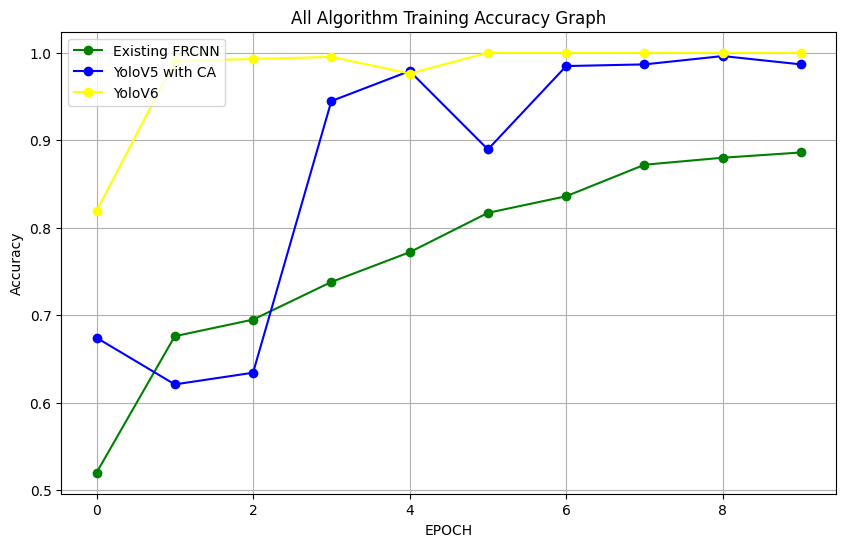

In [19]:
frcnn_acc, frcnn_loss = values("model/frcnn_history.pckl", "accuracy", "loss")
propose_acc, propose_loss = values("model/yolo_history.pckl", "val_class_label_accuracy", "val_loss")
extension_acc, extension_loss = values("model/yolov6.pckl", "val_class_accuracy", "val_loss")
    
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('EPOCH')
plt.ylabel('Accuracy')
plt.plot(frcnn_acc, 'ro-', color = 'green')
plt.plot(propose_acc, 'ro-', color = 'blue')
plt.plot(extension_acc, 'ro-', color = 'yellow')
plt.legend(['Existing FRCNN', 'YoloV5 with CA','YoloV6'], loc='upper left')
plt.title('All Algorithm Training Accuracy Graph')
plt.show()

In [20]:
def predict(image_path):
    img = cv2.imread(image_path)#read test image
    img = cv2.resize(img, (32, 32), interpolation = cv2.INTER_CUBIC) #scale imaage
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)#hsv transform
    img = cv2.flip(img, 1)#flip images
    img = img.reshape(1,32,32,3)#convert image as 4 dimension
    predict = yolov6_model.predict(img)#predict solar defect from test image
    predict_label = predict[1] #get classification defect labels
    defect_probability = predict[0][0][0]#get defect probability
    predict_label = np.argmax(predict_label)
    img = cv2.imread(image_path)
    img = cv2.resize(img, (600,400))#display image with predicted output
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.putText(img, 'Predicted As : '+labels[predict_label], (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (255, 0, 0), 2)
    cv2.putText(img, 'Defect Probability : '+str(defect_probability), (10, 65),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (255, 0, 0), 2)
    plt.imshow(img)
    

1/1 [==============================] - 0s 97ms/step


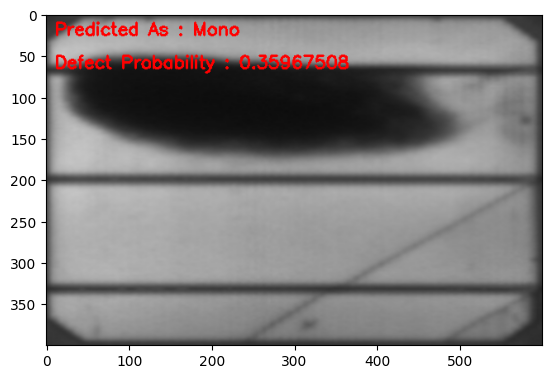

In [21]:
#call this function to detect defect from solar surface
predict("testImages/2.png")

1/1 [==============================] - 0s 89ms/step


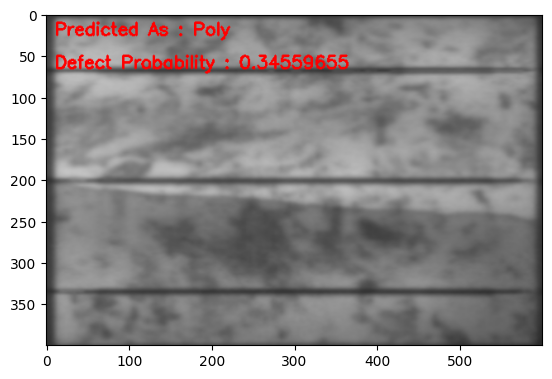

In [22]:
#call this function to detect defect from solar surface
predict("testImages/3.png")

1/1 [==============================] - 0s 86ms/step


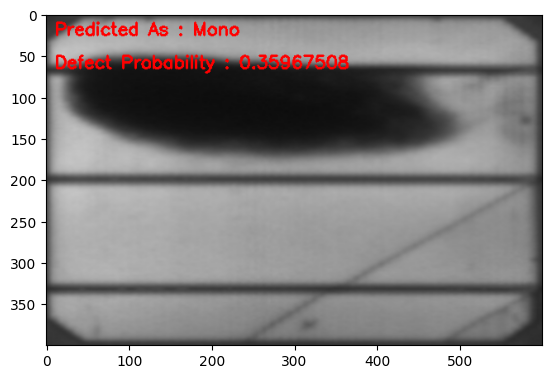

In [23]:
#call this function to detect defect from solar surface
predict("testImages/2.png")

1/1 [==============================] - 0s 91ms/step


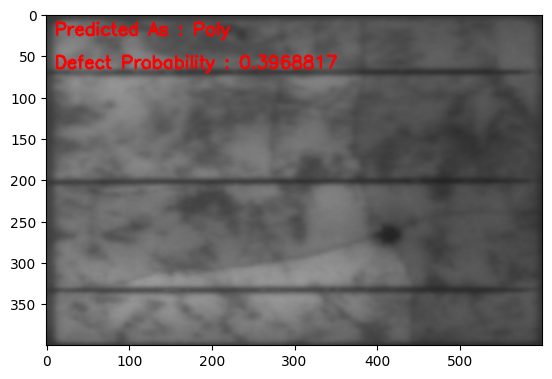

In [24]:
#call this function to detect defect from solar surface
predict("testImages/4.png")

1/1 [==============================] - 0s 86ms/step


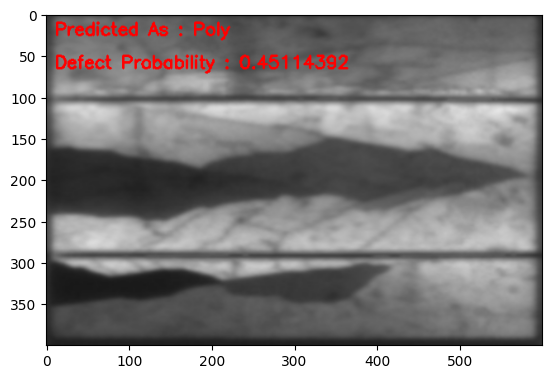

In [25]:
#call this function to detect defect from solar surface
predict("testImages/5.png")

In [23]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import cv2
import numpy as np

# Your prediction function
def predict(image_path):
    img = cv2.imread(image_path)#read test image
    img = cv2.resize(img, (32, 32), interpolation = cv2.INTER_CUBIC) #scale imaage
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)#hsv transform
    img = cv2.flip(img, 1)#flip images
    img = img.reshape(1,32,32,3)#convert image as 4 dimension
    predict = yolov6_model.predict(img)#predict solar defect from test image
    predict_label = predict[1] #get classification defect labels
    defect_probability = predict[0][0][0]#get defect probability
    predict_label = np.argmax(predict_label)
    img = cv2.imread(image_path)
    img = cv2.resize(img, (600,400))#display image with predicted output
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.putText(img, 'Predicted As : '+labels[predict_label], (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,0.5, (255, 0, 0), 2)
    cv2.putText(img, 'Defect Probability : '+str(defect_probability), (10, 65),  cv2.FONT_HERSHEY_SIMPLEX,0.5, (255, 0, 0), 2)
    return img

# Function to open file dialog and select image
def select_image():
    global original_img_label, processed_img_label
    file_path = filedialog.askopenfilename()
    if file_path:
        original_img = Image.open(file_path)
        processed_img = predict(file_path)

        # Convert processed image to PIL format
        processed_img = Image.fromarray(processed_img)

        # Resize images if needed
        original_img = original_img.resize((600, 400))
        processed_img = processed_img.resize((600, 400))

        # Display original image
        original_img_label.image = ImageTk.PhotoImage(original_img)
        original_img_label.config(image=original_img_label.image)

        # Display processed image with text
        processed_img_label.image = ImageTk.PhotoImage(processed_img)
        processed_img_label.config(image=processed_img_label.image)

        # Update text labels
        original_text_label.config(text="Original Image")
        processed_text_label.config(text="Processed Image")

# Create main Tkinter window
root = tk.Tk()
root.title("Detection of Solar Cell Surface Defects")
root.geometry("900x550")  # Set window size

# Create a label widget to mimic window title
title_label = tk.Label(root, text="High-Accuracy Detection of Solar Cell Surface Defects using YOLOV6", font=("Helvetica", 20, "bold"), bg="lightgray")
title_label.pack(pady=10)
# Customize window background color
root.config(bg="lightgray")

root.state("zoomed")

upframe = tk.Frame(root)
upframe.pack(pady=10)

# Button to select image
select_button = tk.Button(upframe, text="Select Image", command=select_image, bg="blue", fg="white", width=15, height=1, relief="raised", borderwidth=5, font=("Helvetica", 14, "bold"))
select_button.pack()

# Frame for original image
original_frame = tk.Frame(root, bg="lightgray")
original_frame.pack(side="left", padx=70, pady=10)

# Heading for original image frame
original_heading = tk.Label(original_frame, text="Original Image", bg="lightgray", font=("Helvetica", 16, "bold"))
original_heading.pack(pady=5)

# Label to display original image
original_img_label = tk.Label(original_frame)
original_img_label.pack(pady=5)

# Frame for processed image
processed_frame = tk.Frame(root, bg="lightgray")
processed_frame.pack(side="right", padx=70, pady=10)

# Heading for processed image frame
processed_heading = tk.Label(processed_frame, text="Predicted Image", bg="lightgray", font=("Helvetica", 16, "bold"))
processed_heading.pack(pady=5)

# Label to display processed image
processed_img_label = tk.Label(processed_frame)
processed_img_label.pack(pady=5)

# Run the Tkinter event loop

root.mainloop()


In [ ]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import cv2
import numpy as np

# Declare global variables
original_img_label = None
processed_img_label = None
# Your prediction function
def predict(image_path):
    img = cv2.imread(image_path)#read test image
    img = cv2.resize(img, (32, 32), interpolation = cv2.INTER_CUBIC) #scale imaage
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)#hsv transform
    img = cv2.flip(img, 1)#flip images
    img = img.reshape(1,32,32,3)#convert image as 4 dimension
    predict = yolov6_model.predict(img)#predict solar defect from test image
    predict_label = predict[1] #get classification defect labels
    defect_probability = predict[0][0][0]#get defect probability
    predict_label = np.argmax(predict_label)
    img = cv2.imread(image_path)
    img = cv2.resize(img, (600,400))#display image with predicted output
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.putText(img, 'Predicted As : '+labels[predict_label], (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (249, 69, 33), 2)
    cv2.putText(img, 'Defect Probability : '+str(defect_probability), (10, 65),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (249, 69, 33), 2)
    '''check1 = "Poly"
    check2 = "Mono"
    if labels[predict_label] == check1 and defect_probability >= 0.5:
        cv2.putText(img, 'need to replace or repair the cell', (10, 105),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (249, 69, 33), 2)
    elif labels[predict_label] == check2 and defect_probability >= 0.5:
        cv2.putText(img, 'need to replace or repair the cell', (10, 105),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (249, 69, 33), 2)'''
    return img

# Function to open file dialog and select image
def select_image():
    global original_img_label, processed_img_label
    file_path = filedialog.askopenfilename()
    if file_path:
        original_img = Image.open(file_path)
        processed_img = predict(file_path)

        # Convert processed image to PIL format
        processed_img = Image.fromarray(processed_img)

        # Resize images if needed
        original_img = original_img.resize((600, 400))
        processed_img = processed_img.resize((600, 400))

        # Display original image
        original_img_label.image = ImageTk.PhotoImage(original_img)
        original_img_label.config(image=original_img_label.image)
        original_frame.pack(side="left", padx=70, pady=10)
        original_heading.pack(pady=5)
        original_img_label.pack(pady=5)

        # Display processed image with text
        processed_img_label.image = ImageTk.PhotoImage(processed_img)
        processed_img_label.config(image=processed_img_label.image)
        processed_frame.pack(side="right", padx=70, pady=10)
        processed_heading.pack(pady=5)
        processed_img_label.pack(pady=5)

        # Update text labels
        original_text_label.config(text="Original Image")
        processed_text_label.config(text="Processed Image")

       


# Create main Tkinter window
root = tk.Tk()
root.title("Detection of Solar Cell Surface Defects")
#root.geometry("900x550")  # Set window size
# Load background image
bg_image = Image.open("testImages/wp8084830.jpg")  # Change "background_image.jpg" to the path of your background image
bg_photo = ImageTk.PhotoImage(bg_image)

# Create a Label widget with the background image
bg_label = tk.Label(root, image=bg_photo)
bg_label.place(relwidth=1, relheight=1)
# Create a label widget to mimic window title
title_label = tk.Label(root, text="High-Accuracy Detection of Solar Cell Surface Defects using YOLOV6", font=("Helvetica", 20, "bold"), bg="#A9A9A9")
title_label.pack(pady=10)
# Customize window background color
root.config(bg="lightgray")

root.state("zoomed")

upframe = tk.Frame(root)
upframe.pack(pady=10)

# Button to select image
select_button = tk.Button(upframe, text="Select Image", command=select_image, bg="blue", fg="white", width=15, height=1, relief="raised", borderwidth=5, font=("Helvetica", 14, "bold"))
select_button.pack()

# Frame for original image
original_frame = tk.Frame(root, bg="#A9A9A9")
#original_frame.pack(side="left", padx=70, pady=10)

# Heading for original image frame
original_heading = tk.Label(original_frame, text="Original Image", bg="#A9A9A9", font=("Helvetica", 16, "bold"))
#original_heading.pack(pady=5)

# Label to display original image
original_img_label = tk.Label(original_frame)
#original_img_label.pack(pady=5)

# Frame for processed image
processed_frame = tk.Frame(root, bg="#A9A9A9")
#processed_frame.pack(side="right", padx=70, pady=10)

# Heading for processed image frame
processed_heading = tk.Label(processed_frame, text="Predicted Image", bg="#A9A9A9", font=("Helvetica", 16, "bold"))
#processed_heading.pack(pady=5)

# Label to display processed image
processed_img_label = tk.Label(processed_frame)
#processed_img_label.pack(pady=5)

# Run the Tkinter event loop

root.mainloop()
